In [ ]:
# install kaggle
!pip install -q kaggle

In [ ]:
# upload kaggle.json
from google.colab import files
files.upload()

In [ ]:
# create kaggle folder
!mkdir ~/.kaggle

# copy the kaggle.jason to the folder created
!cp kaggle.json ~/.kaggle/

# permission for the jason to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Loading the Malaria dataset using Kaggle API Command
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 97% 653M/675M [00:04<00:00, 97.2MB/s]
100% 675M/675M [00:04<00:00, 148MB/s] 


In [ ]:
# Unzipping the dataset
!unzip cell-images-for-detecting-malaria.zip

In [ ]:
# making train and test directories
import os

try:
    os.mkdir('/content/images')
    
    os.mkdir('/content/images/train')
    os.mkdir('/content/images/test')
    
    os.mkdir('/content/images/train/parasitized')
    os.mkdir('/content/images/train/uninfected')
    
    os.mkdir('/content/images/test/parasitized')
    os.mkdir('/content/images/test/uninfected')
except OSError:
    pass

In [ ]:
import math
import random
from shutil import copyfile

# train test split function
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    file_list = [file for file in os.listdir(SOURCE) if os.path.getsize(SOURCE+file) != 0]
    
    training_sample = random.sample(file_list, math.floor(len(file_list)*SPLIT_SIZE))
    testing_sample = [file for file in file_list if file not in training_sample]
    
    for file in training_sample:
        copyfile(SOURCE+file, TRAINING+file)
        
    for file in testing_sample:
        copyfile(SOURCE+file, TESTING+file)

In [ ]:
# copying files to train and test folder
parasitized_source_dir = '/content/cell_images/Parasitized/'
parasitized_train_dir = '/content/images/train/parasitized/'
parasitized_test_dir = '/content/images/test/parasitized/'

uninfected_source_dir = '/content/cell_images/Uninfected/'
uninfected_train_dir = '/content/images/train/uninfected/'
uninfected_test_dir = '/content/images/test/uninfected/'

split_size = 0.8
split_data(parasitized_source_dir, parasitized_train_dir, parasitized_test_dir, split_size)
split_data(uninfected_source_dir, uninfected_train_dir, uninfected_test_dir, split_size)

In [ ]:
print(len(os.listdir('/content/images/train/parasitized')))
print(len(os.listdir('/content/images/train/uninfected')))
print(len(os.listdir('/content/images/test/parasitized')))
print(len(os.listdir('/content/images/test/uninfected')))

11024
11024
2756
2756


In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt

# function for display images
def display_images_from_dir(dir_path, nimages):
  images = random.sample(os.listdir(dir_path), nimages)
  images = [dir_path+'/'+image for image in images]

  plt.figure(figsize = (20,5))
  for i, img_path in enumerate(images):
    img = cv.imread(img_path)
    img = cv.cvtColor(img, code = cv.COLOR_BGR2RGB)
    plt.subplot(1,nimages,i+1)
    plt.imshow(img)
  plt.show()

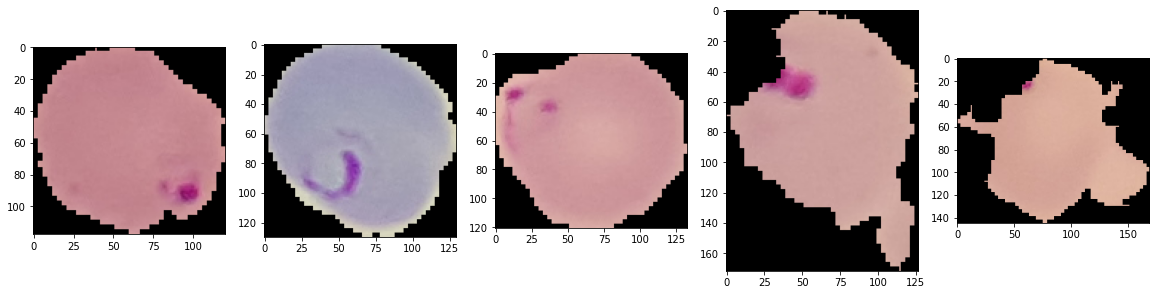

In [ ]:
# parasitized cells
display_images_from_dir('/content/images/train/parasitized', nimages = 5)

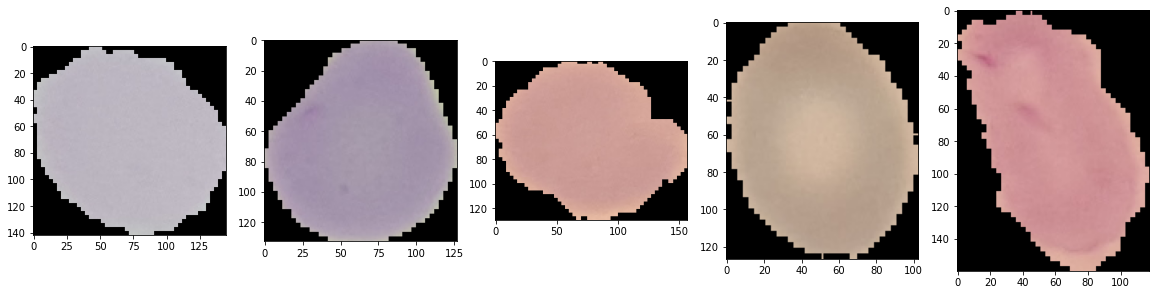

In [ ]:
# uninfected cells
display_images_from_dir('/content/images/train/uninfected', nimages = 5)

In [ ]:
# checking tensorflow version
import tensorflow
print(tensorflow.__version__)

2.7.0


In [ ]:
train_dir = '/content/images/train'
validation_dir = '/content/images/test'
IMG_SIZE = 150
BATCH_SIZE = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical', 
                                                    target_size = (IMG_SIZE, IMG_SIZE)) 

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = BATCH_SIZE,
                                                          class_mode  = 'categorical', 
                                                          target_size = (IMG_SIZE, IMG_SIZE))

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

inception = InceptionV3(input_shape = (IMG_SIZE,IMG_SIZE,3), weights='imagenet', include_top=False)

for layer in inception.layers:
  layer.trainable = False

last_layer = inception.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)

x = Flatten()(last_layer.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=inception.input, outputs = x)

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

87924736/87910968 [==============================] - 1s 0us/step
last layer output shape:  (None, 7, 7, 768)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                         

In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 685,
            epochs = 10,
            validation_steps = 170)

Epoch 1/10
685/685 [==============================] - 85s 106ms/step - loss: 0.2529 - accuracy: 0.9207 - val_loss: 0.1632 - val_accuracy: 0.9426
Epoch 2/10
685/685 [==============================] - 71s 103ms/step - loss: 0.1358 - accuracy: 0.9490 - val_loss: 0.1520 - val_accuracy: 0.9461
Epoch 3/10
685/685 [==============================] - 71s 103ms/step - loss: 0.1112 - accuracy: 0.9585 - val_loss: 0.1889 - val_accuracy: 0.9344
Epoch 4/10
685/685 [==============================] - 71s 103ms/step - loss: 0.0951 - accuracy: 0.9636 - val_loss: 0.1611 - val_accuracy: 0.9458
Epoch 5/10
685/685 [==============================] - 71s 103ms/step - loss: 0.0715 - accuracy: 0.9723 - val_loss: 0.2067 - val_accuracy: 0.9471
Epoch 6/10
685/685 [==============================] - 70s 103ms/step - loss: 0.0622 - accuracy: 0.9768 - val_loss: 0.1884 - val_accuracy: 0.9460
Epoch 7/10
685/685 [==============================] - 70s 103ms/step - loss: 0.0562 - accuracy: 0.9797 - val_loss: 0.1844 - val_ac

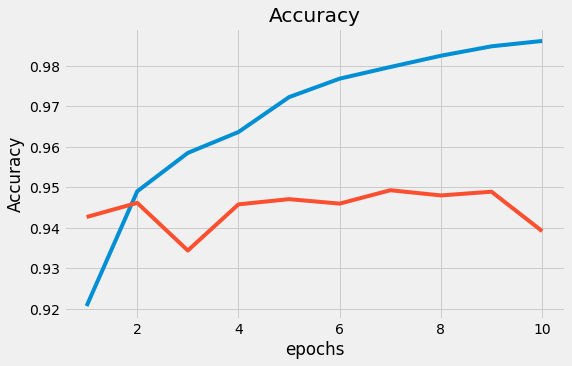

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize = (8,5))
plt.plot(range(1,11), history.history['accuracy'], label = 'train accuracy')
plt.plot(range(1,11), history.history['val_accuracy'], label = 'validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model.save('/content/inceptionV3.h5')